In [1]:
# https://stackoverflow.com/questions/60116208/pytorch-load-dataset-of-grayscale-images
import torch
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
import copy



In [2]:
root = 'data/'

data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                     transforms.Resize((64,64)),
                                     transforms.ToTensor()])
dataset = ImageFolder(root, transform=data_transform)

print(dataset.classes)
print(dataset.class_to_idx)

# Split test and train dataset 
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Set batch size of train data loader
batch_size_train = 20

# Set batch size of test data loader
batch_size_test = 22

# load the split train and test data into batches via DataLoader()
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

label_map={
    0:"Chickenpox",
    1:"Measles",
    2:"Monkeypox",
    3:"Normal"
}
classes = ('Chickenpox', 'Measles', 'Monkeypox', 'Normal')

dataloaders={}
dataloaders["train"]=train_loader
dataloaders["val"]=test_loader

dataset_sizes = {"train":len(train_loader.dataset),"val":len(test_loader.dataset)}



['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
{'Chickenpox': 0, 'Measles': 1, 'Monkeypox': 2, 'Normal': 3}


Text(0.5, 1.0, 'Normal')

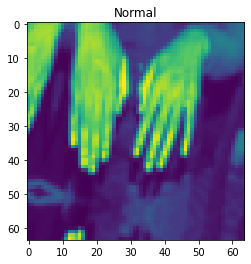

In [33]:
# Looping through it, get a batch on each loop 
for images, labels in train_loader:
    pass

# Get one batch
images, labels = next(iter(train_loader))

indx=10
plt.imshow(images[indx].reshape(64,64))
plt.title(label_map[int(labels[indx].numpy())])


In [9]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs=30

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.repeat(1, 3, 1, 1)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def accuracy(model, test_loader) :
    model.eval()
    with torch.no_grad():
        running_corrects=0
        for inputs, labels in test_loader:
            inputs = inputs.repeat(1, 3, 1, 1)
            inputs = inputs.to(device)
            labels = labels.to(device) 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        acc = running_corrects.double() / dataset_sizes["val"]
    return acc



In [10]:


from collections import Counter

train_classes = [dataset.targets[i] for i in train_data.indices]
print("train:",Counter(train_classes)) # if doesn' work: Counter(i.item() for i in train_classes)

test_classes = [dataset.targets[i] for i in test_data.indices]
print("Test:",Counter(test_classes)) # if doesn' work: Counter(i.item() for i in train_classes)

print("Total:",dict(Counter(test_data.dataset.targets)))

train: Counter({2: 439, 3: 428, 0: 249, 1: 216})
Test: Counter({2: 191, 3: 157, 0: 127, 1: 97})
Total: {0: 376, 1: 313, 2: 630, 3: 585}


### Train a resnet18

In [13]:
PATH = './resnet18_net.pth'

# setup
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)
torch.save(model_ft.state_dict(), PATH)

# load
model_ft3 = models.resnet18(pretrained=True)
num_ftrs = model_ft3.fc.in_features
model_ft3.fc = nn.Linear(num_ftrs, len(classes))
model_ft3.to(device)
model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

# test
print(accuracy(model_ft3, test_loader))

Epoch 0/29
----------
train Loss: 1.0691 Acc: 0.5368
val Loss: 0.9278 Acc: 0.6486

Epoch 1/29
----------
train Loss: 0.4686 Acc: 0.8086
val Loss: 0.8326 Acc: 0.6923

Epoch 2/29
----------
train Loss: 0.2844 Acc: 0.8934
val Loss: 0.7692 Acc: 0.7063

Epoch 3/29
----------
train Loss: 0.2159 Acc: 0.9152
val Loss: 0.5397 Acc: 0.7937

Epoch 4/29
----------
train Loss: 0.1805 Acc: 0.9317
val Loss: 1.0242 Acc: 0.6976

Epoch 5/29
----------
train Loss: 0.1224 Acc: 0.9565
val Loss: 0.6539 Acc: 0.7710

Epoch 6/29
----------
train Loss: 0.0883 Acc: 0.9737
val Loss: 0.6372 Acc: 0.7797

Epoch 7/29
----------
train Loss: 0.0545 Acc: 0.9857
val Loss: 0.6539 Acc: 0.7920

Epoch 8/29
----------
train Loss: 0.0531 Acc: 0.9872
val Loss: 0.6410 Acc: 0.7850

Epoch 9/29
----------
train Loss: 0.0458 Acc: 0.9887
val Loss: 0.6418 Acc: 0.7885

Epoch 10/29
----------
train Loss: 0.0329 Acc: 0.9940
val Loss: 0.6473 Acc: 0.7920

Epoch 11/29
----------
train Loss: 0.0476 Acc: 0.9865
val Loss: 0.6503 Acc: 0.7780

Ep

tensor(0.9423, dtype=torch.float64)


tensor(0.9423, dtype=torch.float64)


### Train an AlexNet

In [18]:
PATH = './alex_net.pth'

# setup
model_ft = models.alexnet(pretrained=True,)
model_ft.classifier[6] = nn.Linear(4096,len(classes))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

# load
model_ft3 = models.alexnet(pretrained=True)
model_ft3.classifier[6] = nn.Linear(4096,len(classes))
model_ft3.to(device)
model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

# test
print(accuracy(model_ft3, test_loader))

Epoch 0/29
----------
train Loss: 1.2148 Acc: 0.4842
val Loss: 1.0539 Acc: 0.5664

Epoch 1/29
----------
train Loss: 0.9269 Acc: 0.6141
val Loss: 0.9223 Acc: 0.6119

Epoch 2/29
----------
train Loss: 0.8132 Acc: 0.6689
val Loss: 0.8622 Acc: 0.6101

Epoch 3/29
----------
train Loss: 0.7476 Acc: 0.6854
val Loss: 0.8747 Acc: 0.6119

Epoch 4/29
----------
train Loss: 0.6387 Acc: 0.7252
val Loss: 0.8555 Acc: 0.6608

Epoch 5/29
----------
train Loss: 0.5438 Acc: 0.7748
val Loss: 0.7884 Acc: 0.6748

Epoch 6/29
----------
train Loss: 0.4531 Acc: 0.8131
val Loss: 0.7430 Acc: 0.6643

Epoch 7/29
----------
train Loss: 0.2928 Acc: 0.8941
val Loss: 0.6561 Acc: 0.7220

Epoch 8/29
----------
train Loss: 0.2403 Acc: 0.9092
val Loss: 0.6515 Acc: 0.7203

Epoch 9/29
----------
train Loss: 0.2097 Acc: 0.9234
val Loss: 0.6619 Acc: 0.7255

Epoch 10/29
----------
train Loss: 0.2038 Acc: 0.9219
val Loss: 0.6565 Acc: 0.7220

Epoch 11/29
----------
train Loss: 0.1922 Acc: 0.9294
val Loss: 0.6722 Acc: 0.7185

Ep

tensor(0.9021, dtype=torch.float64)


### densenet121

In [43]:
PATH = './densenet121.pth'

In [24]:

model_ft = models.densenet121(pretrained=True,)
model_ft.classifier=nn.Linear(1024,len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

Epoch 0/29
----------
train Loss: 0.9855 Acc: 0.5781
val Loss: 0.6621 Acc: 0.7080

Epoch 1/29
----------
train Loss: 0.5064 Acc: 0.7905
val Loss: 0.5588 Acc: 0.7255

Epoch 2/29
----------
train Loss: 0.3218 Acc: 0.8619
val Loss: 0.5623 Acc: 0.7465

Epoch 3/29
----------
train Loss: 0.2344 Acc: 0.9107
val Loss: 0.4963 Acc: 0.7955

Epoch 4/29
----------
train Loss: 0.1545 Acc: 0.9452
val Loss: 0.5818 Acc: 0.7675

Epoch 5/29
----------
train Loss: 0.1026 Acc: 0.9640
val Loss: 0.5560 Acc: 0.7937

Epoch 6/29
----------
train Loss: 0.0927 Acc: 0.9692
val Loss: 0.6066 Acc: 0.7832

Epoch 7/29
----------
train Loss: 0.0654 Acc: 0.9835
val Loss: 0.6022 Acc: 0.8059

Epoch 8/29
----------
train Loss: 0.0562 Acc: 0.9857
val Loss: 0.6271 Acc: 0.8059

Epoch 9/29
----------
train Loss: 0.0486 Acc: 0.9865
val Loss: 0.6093 Acc: 0.8077

Epoch 10/29
----------
train Loss: 0.0394 Acc: 0.9925
val Loss: 0.6042 Acc: 0.8077

Epoch 11/29
----------
train Loss: 0.0391 Acc: 0.9925
val Loss: 0.6128 Acc: 0.7867

Ep

In [44]:
model_ft3 = models.densenet121(pretrained=True)
model_ft3.classifier=nn.Linear(1024,len(classes))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()
print(accuracy(model_ft3, test_loader))

tensor(0.9458, dtype=torch.float64)


tensor(0.8112, dtype=torch.float64)
tensor(0.8112, dtype=torch.float64)


### densenet161

In [45]:
PATH = './densenet161.pth'

In [46]:
model_ft = models.densenet161(pretrained=True,)
model_ft.classifier=nn.Linear(2208,len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

Epoch 0/29
----------
train Loss: 0.9851 Acc: 0.5848
val Loss: 0.9174 Acc: 0.6066

Epoch 1/29
----------


In [53]:
model_ft3 = models.densenet161(pretrained=True)
model_ft3.classifier=nn.Linear(2208,len(classes))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()


print(accuracy(model_ft3, test_loader))


tensor(0.8234, dtype=torch.float64)


### densenet169

In [55]:
PATH = './densenet169.pth'

model_ft = models.densenet169(pretrained=True,)
print(model_ft.classifier)
model_ft.classifier=nn.Linear(1664,len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

#test
model_ft3 = models.densenet169(pretrained=True)
model_ft3.classifier=nn.Linear(1664,len(classes))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()


print(accuracy(model_ft3, test_loader))


Linear(in_features=1664, out_features=1000, bias=True)


Epoch 0/29
----------
train Loss: 1.0273 Acc: 0.5623
val Loss: 0.6742 Acc: 0.7343

Epoch 1/29
----------
train Loss: 0.5404 Acc: 0.7688
val Loss: 0.4912 Acc: 0.7955

Epoch 2/29
----------
train Loss: 0.3692 Acc: 0.8483
val Loss: 0.4655 Acc: 0.7972

Epoch 3/29
----------
train Loss: 0.2323 Acc: 0.9062
val Loss: 0.5805 Acc: 0.7657

Epoch 4/29
----------
train Loss: 0.1626 Acc: 0.9437
val Loss: 0.5288 Acc: 0.7955

Epoch 5/29
----------
train Loss: 0.1296 Acc: 0.9535
val Loss: 0.6158 Acc: 0.7920

Epoch 6/29
----------
train Loss: 0.0966 Acc: 0.9685
val Loss: 0.5652 Acc: 0.8147

Epoch 7/29
----------
train Loss: 0.0734 Acc: 0.9767
val Loss: 0.5661 Acc: 0.8059

Epoch 8/29
----------
train Loss: 0.0561 Acc: 0.9842
val Loss: 0.5721 Acc: 0.8007

Epoch 9/29
----------
train Loss: 0.0537 Acc: 0.9880
val Loss: 0.5821 Acc: 0.8042

Epoch 10/29
----------
train Loss: 0.0462 Acc: 0.9895
val Loss: 0.5572 Acc: 0.8147

Epoch 11/29
----------
train Loss: 0.0349 Acc: 0.9932
val Loss: 0.5434 Acc: 0.8199

Ep

tensor(0.8199, dtype=torch.float64)


### densenet201

In [58]:
PATH = './densenet201.pth'

In [59]:
model_ft = models.densenet201(pretrained=True,)
# print(model_ft.classifier)
model_ft.classifier=nn.Linear(1920,len(classes))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [60]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

Epoch 0/29
----------
train Loss: 1.0028 Acc: 0.5563
val Loss: 0.7860 Acc: 0.6713

Epoch 1/29
----------
train Loss: 0.5152 Acc: 0.7755
val Loss: 0.6138 Acc: 0.7308

Epoch 2/29
----------
train Loss: 0.3019 Acc: 0.8761
val Loss: 0.5090 Acc: 0.7867

Epoch 3/29
----------
train Loss: 0.1915 Acc: 0.9377
val Loss: 0.5190 Acc: 0.8024

Epoch 4/29
----------
train Loss: 0.1265 Acc: 0.9527
val Loss: 0.5533 Acc: 0.7902

Epoch 5/29
----------
train Loss: 0.0975 Acc: 0.9655
val Loss: 0.5692 Acc: 0.8059

Epoch 6/29
----------
train Loss: 0.0802 Acc: 0.9760
val Loss: 0.6513 Acc: 0.8077

Epoch 7/29
----------
train Loss: 0.0538 Acc: 0.9887
val Loss: 0.5972 Acc: 0.8059

Epoch 8/29
----------
train Loss: 0.0377 Acc: 0.9940
val Loss: 0.5962 Acc: 0.8077

Epoch 9/29
----------
train Loss: 0.0393 Acc: 0.9925
val Loss: 0.5950 Acc: 0.8042

Epoch 10/29
----------
train Loss: 0.0332 Acc: 0.9947
val Loss: 0.5846 Acc: 0.8077

Epoch 11/29
----------
train Loss: 0.0276 Acc: 0.9962
val Loss: 0.6031 Acc: 0.8059

Ep

In [61]:
model_ft3 = models.densenet201(pretrained=True)
model_ft3.classifier=nn.Linear(1920,len(classes))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()
print(accuracy(model_ft3, test_loader))

tensor(0.8199, dtype=torch.float64)


### squeezenet1_0

In [63]:
PATH = './squeezenet1_0.pth'

# setup
model_ft = models.squeezenet1_0(pretrained=True,)
model_ft.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1,1), stride=(1,1))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

# load
model_ft3 = models.squeezenet1_0(pretrained=True,)
model_ft3.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1,1), stride=(1,1))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

# test
print(accuracy(model_ft3, test_loader))

Epoch 0/29
----------
train Loss: 1.2914 Acc: 0.4024
val Loss: 1.2132 Acc: 0.4248

Epoch 1/29
----------
train Loss: 1.0976 Acc: 0.5203
val Loss: 0.9884 Acc: 0.5927

Epoch 2/29
----------
train Loss: 0.9546 Acc: 0.6044
val Loss: 0.8255 Acc: 0.6503

Epoch 3/29
----------
train Loss: 0.8907 Acc: 0.6359
val Loss: 0.8686 Acc: 0.6503

Epoch 4/29
----------
train Loss: 0.7589 Acc: 0.6862
val Loss: 0.7691 Acc: 0.6503

Epoch 5/29
----------
train Loss: 0.7208 Acc: 0.7020
val Loss: 0.6769 Acc: 0.7133

Epoch 6/29
----------
train Loss: 0.5873 Acc: 0.7470
val Loss: 0.5981 Acc: 0.7028

Epoch 7/29
----------
train Loss: 0.4442 Acc: 0.8026
val Loss: 0.5538 Acc: 0.7360

Epoch 8/29
----------
train Loss: 0.4051 Acc: 0.8213
val Loss: 0.5525 Acc: 0.7168

Epoch 9/29
----------
train Loss: 0.3808 Acc: 0.8371
val Loss: 0.5445 Acc: 0.7430

Epoch 10/29
----------
train Loss: 0.3563 Acc: 0.8491
val Loss: 0.5396 Acc: 0.7500

Epoch 11/29
----------
train Loss: 0.3399 Acc: 0.8506
val Loss: 0.5431 Acc: 0.7483

Ep

In [64]:
print(accuracy(model_ft3, test_loader))

tensor(0.7570, dtype=torch.float64)


### squeezenet1_1

In [65]:
PATH = './squeezenet1_1.pth'

In [66]:
model_ft = models.squeezenet1_1(pretrained=True,)
# print(model_ft.classifier)
model_ft.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1,1), stride=(1,1))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [67]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

torch.save(model_ft.state_dict(), PATH)

Epoch 0/29
----------
train Loss: 1.3788 Acc: 0.3258
val Loss: 1.2653 Acc: 0.4371

Epoch 1/29
----------
train Loss: 1.2599 Acc: 0.4174
val Loss: 1.2406 Acc: 0.3829

Epoch 2/29
----------
train Loss: 1.1754 Acc: 0.4662
val Loss: 1.0596 Acc: 0.5787

Epoch 3/29
----------
train Loss: 1.0495 Acc: 0.5571
val Loss: 1.0621 Acc: 0.5455

Epoch 4/29
----------
train Loss: 0.9331 Acc: 0.6156
val Loss: 0.8485 Acc: 0.6731

Epoch 5/29
----------
train Loss: 0.8868 Acc: 0.6351
val Loss: 0.8605 Acc: 0.6591

Epoch 6/29
----------
train Loss: 0.8282 Acc: 0.6569
val Loss: 0.9219 Acc: 0.6101

Epoch 7/29
----------
train Loss: 0.6631 Acc: 0.7117
val Loss: 0.6918 Acc: 0.6923

Epoch 8/29
----------
train Loss: 0.5833 Acc: 0.7635
val Loss: 0.6670 Acc: 0.7273

Epoch 9/29
----------
train Loss: 0.5713 Acc: 0.7643
val Loss: 0.6514 Acc: 0.7273

Epoch 10/29
----------
train Loss: 0.5444 Acc: 0.7763
val Loss: 0.6415 Acc: 0.7413

Epoch 11/29
----------
train Loss: 0.5216 Acc: 0.7755
val Loss: 0.6299 Acc: 0.7343

Ep

In [68]:
model_ft3 = models.squeezenet1_1(pretrained=True,)
model_ft3.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1,1), stride=(1,1))
model_ft3.to(device)

model_ft3.load_state_dict(torch.load(PATH,map_location=device))
model_ft3.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [69]:
print(accuracy(model_ft3, test_loader))



tensor(0.7413, dtype=torch.float64)
